In [1]:
!pip install -r requirements.txt

In [2]:
import time
import os

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import torch
import torch.utils.data

from torch import nn, optim
from torch.autograd import Variable
from torch.nn import functional as F
from torchsummary import summary
from IPython import display

In [3]:
%matplotlib inline
mpl.style.use('dark_background')
np.random.seed(42)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')

Using device: cpu


# Uncertainty Quantification

## Types of uncertainty

**Epistemic (or systematic) uncertainty** is related to inadequate modelling of the data-generating process due to limited data and prior knowledge. It is due to properties of the data generation that one could in principle know, but does not.

**Aleatoric (or statistical) uncertainty** is due to stochasticity inherent to the data-generating process itself. This differs from systematic uncertainty in the sense that aleatoric uncertainty cannot be removed but must rather be modelled by estimation of its size.

Besides quantifying the uncertainties, another goal of uncertainty quantification is to reduce epistemic uncertainties to aleatoric ones.

## Uncertainty and neural networks
Neural networks are well-known to be powerful function approximators and they posess good interpolation abilities. Their ability to extrapolate (or generalize) to the outside of the training data domain however is often poor while the probabilities they assign their predictions in these cases often stay very high.

## Data generating process with aleatory uncertainty
Let $f: \mathbb{R} \rightarrow \mathbb{R}$ be the data-generating process for the example considered in this notebook. The function will include some stochasticity, simulated here by the normal random variable $\epsilon$. We can write the mapping of any input $x_i$ to the output $y_i$ as

$$ y_i = f(x_i) + \epsilon_i, \hspace{1cm} \epsilon_i \sim \mathcal{N}(0,\sigma^2)$$

Concretely, Let

$$f(x_i) = 2 \sin(x_i + 0.5) + 3 \cos(0.7 x_i)$$

Let's sample some training, validation and test data from this function and visualize it.

In [4]:
# Data generating function and data
N_SAMPLES = 300  # Training data samples
SIGMA = 1  # Data standard deviation

SAVE_PATH = 'checkpoints'

PLOT_EVERY = 10
BATCH_SIZE = 16

N_EPOCHS = 750
DIMS = [30, 30, 20]
N_ENSEMBLE_MODELS = 5

In [5]:
# Data generating function
def f(x, sigma=0):
    y = 2 * np.sin(x + 0.5) + 3 * np.cos(0.7 * x)
    eps = np.random.normal(loc=0, scale=sigma, size=x.shape)
    return y + eps

In [6]:
# Training data
x_1 = np.random.uniform(-13, -2, size=N_SAMPLES // 2)
x_2 = np.random.uniform(0, 13, size=N_SAMPLES // 2)
x_train = np.concatenate([x_1, x_2]).reshape(N_SAMPLES, 1)
y_train = f(x_train, sigma=SIGMA)

# Validation data
x_1 = np.random.uniform(-13, -2, size=N_SAMPLES // (2 * 5))
x_2 = np.random.uniform(0, 13, size=N_SAMPLES // (2 * 5))
x_val = np.concatenate([x_1, x_2]).reshape(N_SAMPLES // 5, 1)
y_val = f(x_val, sigma=SIGMA)

# Test data (
x_test = np.random.uniform(-20, 20, size=N_SAMPLES // 5).reshape(N_SAMPLES // 5, 1)
y_test = f(x_test, sigma=SIGMA)

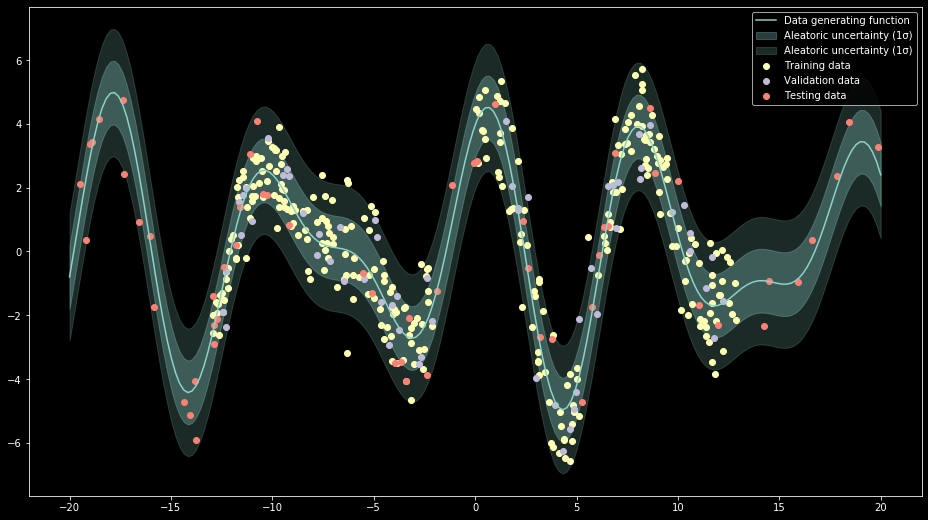

In [7]:
x_plot = np.linspace(-20, 20, num=200)
fig, ax = plt.subplots(1, 1, figsize=(16, 9))
ax.plot(x_plot, f(x_plot), label='Data generating function', color='C0')
ax.fill_between(x_plot, f(x_plot) - SIGMA, f(x_plot) + SIGMA, alpha=0.3, color='C0', label='Aleatoric uncertainty (1σ)')
ax.fill_between(x_plot, f(x_plot) - 2 * SIGMA, f(x_plot) + 2 * SIGMA, alpha=0.2, color='C0', label='Aleatoric uncertainty (1σ)')
ax.scatter(x_train, y_train, color='C1', label='Training data')
ax.scatter(x_val, y_val, color='C2', label='Validation data')
ax.scatter(x_test, y_test, color='C3', label='Testing data')
ax.legend()

## Datasets and training loops
The below defines datasets on the sampled data and the training and test loop code.

In [8]:
# Datset and loader
dataset_train = torch.utils.data.TensorDataset(torch.Tensor(x_train), torch.Tensor(y_train))
dataset_val = torch.utils.data.TensorDataset(torch.Tensor(x_val), torch.Tensor(y_val))
dataset_test = torch.utils.data.TensorDataset(torch.Tensor(x_test), torch.Tensor(y_test))

dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=BATCH_SIZE)
dataloader_val = torch.utils.data.DataLoader(dataset_val, batch_size=BATCH_SIZE)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=BATCH_SIZE)

In [25]:
def train_epoch(epoch, model, loss, optimizer, dataloader):
    model.train()
    total_loss = 0
    for i, (x_batch, y_batch) in enumerate(dataloader, start=1):
        x_batch.to(device)
        y_batch.to(device)
        optimizer.zero_grad()
        output = model.forward(x_batch)
        loss_batch = loss(y_batch, output)
        loss_batch.backward()
        optimizer.step()
        total_loss += loss_batch.item()

    return total_loss / i


def test_epoch(epoch, model, loss, dataloader, eval_mode=True):
    if eval_mode:
        model.eval()
    else:
        model.train()
    total_loss = 0
    with torch.no_grad():
        for i, (x_batch, y_batch) in enumerate(dataloader, start=1):
            x_batch.to(device)
            y_batch.to(device)
            output = model.forward(x_batch)
            loss_batch = loss(y_batch, output)
            total_loss += loss_batch.item()

    return total_loss / i


def train(model, optimizer, loss, dataloader_train, dataloader_val, dataloader_test, n_epochs, fig=None, ax_train=None, ax_func=None, do_plot=True):
    if do_plot and fig is N ax_train is None and ax_func is None:
        fig, (ax_train, ax_func) = plt.subplots(2, 1, figsize=(16, 15))

    train_losses, val_losses, test_losses = [], [], []
    t_plotted = time.time()
    for epoch in range(n_epochs):
        train_loss = train_epoch(epoch, model, loss, optimizer, dataloader_train)
        val_loss = test_epoch(epoch, model, loss, dataloader_val)
        test_loss = test_epoch(epoch, model, loss, dataloader_test)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        test_losses.append(test_loss)

        if do_plot and (epoch == 0 or epoch == N_EPOCHS - 1 or PLOT_EVERY < time.time() - t_plotted):
            t_plotted = time.time()

            plot_learning_curve(ax_train, epoch, {'Train': train_losses, 'Validation': val_losses, 'Test': test_losses})
            plot_learned_function(ax_func, model, x_plot)

            display.display(fig)
            display.clear_output(wait=True)

        print(f'Epoch {epoch:3d} | Train loss {train_loss:2.3f} | Val loss {val_loss:2.3f} | Test loss {test_loss:2.3f}', end='\r')

    torch.save(model.state_dict(), os.path.join(SAVE_PATH, f'{model.__class__.__name__}_model_state_dict.pkl'))


def plot_learned_function(ax, model, x_plot):
    with torch.no_grad():
        x_plot_tensor = torch.Tensor(x_plot.reshape(-1, 1))
        x_plot_tensor.to(device)
        y_pred, pred_variance = model.predict(x_plot_tensor)
        y_pred = y_pred.flatten()
        if isinstance(pred_variance, tuple):
            aleatory_std = pred_variance[0].flatten().sqrt()
            epistemic_std = pred_variance[1].flatten().sqrt()
        else:
            aleatory_std = pred_variance.flatten().sqrt()
            epistemic_std = None

    ax.clear()
    ax.plot(x_plot, f(x_plot), color='C0', label='Data generating function')
    ax.scatter(x_train, y_train, color='C0', label='Training data')
    ax.scatter(x_val, y_val, color='C2', label='Validation data')
    ax.scatter(x_test, y_test, color='C3', label='Testing data')
    ax.plot(x_plot, y_pred, color='C1', label='Learned mean function')
    for i in range(3):
        ax.fill_between(
            x_plot,
            y_pred - (i + 1) * aleatory_std,
            y_pred + (i + 1) * aleatory_std,
            alpha=0.3 - 0.1 * i,
            color='C1',
            label=f'Aleatory uncertainty ({i + 1}σ)'
        )
    if epistemic_std is not None:
        for i in range(3):
            # Above
            ax.fill_between(
                x_plot,
                y_pred + 3 * aleatory_std,
                y_pred + 3 * aleatory_std + (i + 1) * epistemic_std,
                alpha=0.3 - 0.1 * i,
                color='C3',
                label=f'Epistemic uncertainty ({i + 1}σ)'
            )
            # Below
            ax.fill_between(
                x_plot,
                y_pred - 3 * aleatory_std,
                y_pred - 3 * aleatory_std - (i + 1) * epistemic_std,
                alpha=0.3 - 0.1 * i,
                color='C3',
            )
    ax.set_ylim([-10, 10])
    ax.legend()


def plot_learning_curve(ax, epoch, loss_series):
    ax.clear()
    ax.set_ylabel('Loss')
    ax.set_xlabel('Epoch')
    ax.set_title('Learning curves')
    ax.set_yscale('log')
    for label, series in loss_series.items():
        ax.plot(range(epoch + 1), series, label=label)
    ax.legend()

# Methods for modelling uncertainty

## Monte Carlo Dropout
As proposed in \[1\], the widely used regularization technique *Dropout* can be used to provide uncertainty estimates for a models predictions. This is in line with the interpretation of dropout as a form of model ensembling or averaging \[2\].

Typically, dropout is applied at train-time and deactivated at test-time in order to exploit the full power of the "model ensemble". If instead we also apply dropout at test-time and do several forward passes of the same input $x$, we can expect to get a different prediction every time with some variance. We can use this to deduce an empirical distribution over the outputs given the inputs $p(y|x)$. In turn. we can then use this distribution to estimate an empirical mean and variance of the mean of the predictions.

We expect that the empirical variance of the mean is low for inputs originating from dense regions of the input space since more sub-networks were presented with data from these regions. In more sparsely sampled regions of the input space or regions with no data at all, we expect the spread in sub-network behaviour to be higher. This corresponds to the desired behavior for the uncertainty estimation.

In [10]:
RATES = [0.0, 0.2, 0.2, 0.1]

In [11]:
class MCDModel(nn.Module):
    def __init__(self, dims=[1, *DIMS, 1], rates=[0.3, 0.2, 0.2, 0.1], batchnorm=False):
        """
        Args:
            dims (list): Number of units in each of the layers including input and output.
            rates (list): Probability of dropping any activation in the representation immediately before any linear transformation.
        """
        super().__init__()
        self.layers = []

        self.layers.append(nn.Dropout(p=rates[0]))
        self.layers.append(nn.Linear(dims[0], dims[1]))
        for i in range(1, len(dims) - 1):
            if batchnorm:
                self.layers.append(nn.BatchNorm1d(dims[i]))
            self.layers.append(nn.ReLU())
            self.layers.append(nn.Dropout(p=rates[i]))
            self.layers.append(nn.Linear(dims[i], dims[i + 1]))

        for i, layer in enumerate(self.layers):
            setattr(self, layer.__class__.__name__ + f'_{i}', layer)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def predict(self, x, n_repeats=40):
        self.train()
        y_pred = []
        for i in range(n_repeats):
            y_pred.append(self.forward(x))
        y_pred = torch.stack(y_pred)  # Create new axis (Repeats, Batch, Dims)
        return torch.mean(y_pred, axis=0), torch.var(y_pred, axis=0)

In [12]:
# Initialize model parameters and setup
mcd_model = MCDModel(rates=RATES)
mcd_model.to(device)
print(summary(model=mcd_model, input_size=(1,), device=device))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Dropout-1                    [-1, 1]               0
            Linear-2                   [-1, 30]              60
              ReLU-3                   [-1, 30]               0
           Dropout-4                   [-1, 30]               0
            Linear-5                   [-1, 30]             930
              ReLU-6                   [-1, 30]               0
           Dropout-7                   [-1, 30]               0
            Linear-8                   [-1, 20]             620
              ReLU-9                   [-1, 20]               0
          Dropout-10                   [-1, 20]               0
           Linear-11                    [-1, 1]              21
Total params: 1,631
Trainable params: 1,631
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/back

In [13]:
mse_loss = nn.MSELoss(reduction='mean')
mse_loss.to(device)
optimizer = optim.Adam(mcd_model.parameters(), lr=1e-3)

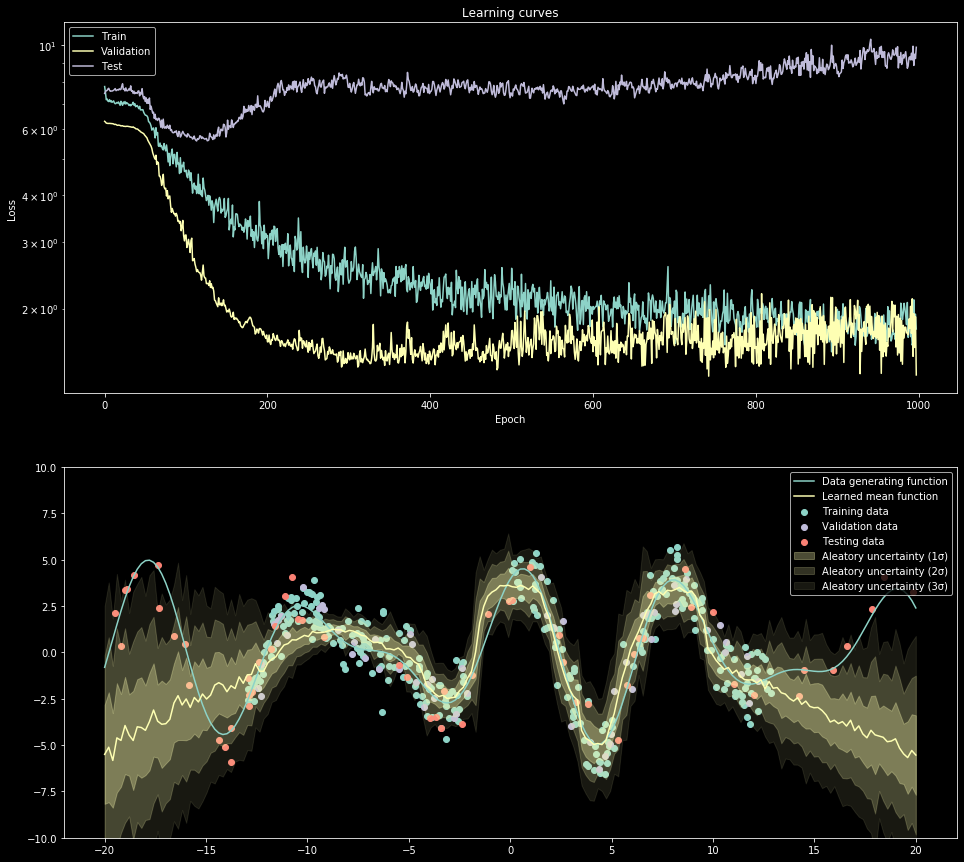

In [14]:
train(mcd_model, optimizer, mse_loss, dataloader_train, dataloader_val, dataloader_test, 1000)

## Distributional Parameter Learning

In [15]:
class GaussianNLLLoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, mu_true, pred_parameters):
        mu_pred, log_var_pred = pred_parameters
        return torch.mean(log_var_pred / (2) + (mu_true - mu_pred).pow(2) / (2 * log_var_pred.exp()), axis=0)

In [16]:
class DPLModel(nn.Module):
    """Distributional Parameter Learning Model using Gaussian"""
    def __init__(self, dims=[1, *DIMS, 2], batchnorm=False):
        super().__init__()
        self.layers = []

        self.layers.append(nn.Linear(dims[0], dims[1]))
        for i in range(1, len(dims) - 1):
            if batchnorm:
                bn = nn.BatchNorm1d(dims[i])
                self.layers.append(bn)
            relu = nn.ReLU()
            self.layers.append(relu)
            lin = nn.Linear(dims[i], dims[i + 1])
            self.layers.append(lin)

        for i, layer in enumerate(self.layers):
            setattr(self, layer.__class__.__name__ + f'_{i}', layer)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        mu = x[..., 0:1]
        logvar = x[..., 1:2]
        return mu, logvar

    def predict(self, x):
        mu, logvar = self.forward(x)
        return mu, logvar.exp()

In [17]:
# Initialize model parameters and setup
dpl_model = DPLModel()
dpl_model.to(device)
print(summary(model=dpl_model, input_size=(1,), device=device))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 30]              60
              ReLU-2                   [-1, 30]               0
            Linear-3                   [-1, 30]             930
              ReLU-4                   [-1, 30]               0
            Linear-5                   [-1, 20]             620
              ReLU-6                   [-1, 20]               0
            Linear-7                    [-1, 2]              42
Total params: 1,652
Trainable params: 1,652
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.01
Estimated Total Size (MB): 0.01
----------------------------------------------------------------
None


In [18]:
gaussian_nll_loss = GaussianNLLLoss()
gaussian_nll_loss.to(device)
optimizer = optim.Adam(dpl_model.parameters(), lr=3e-4)

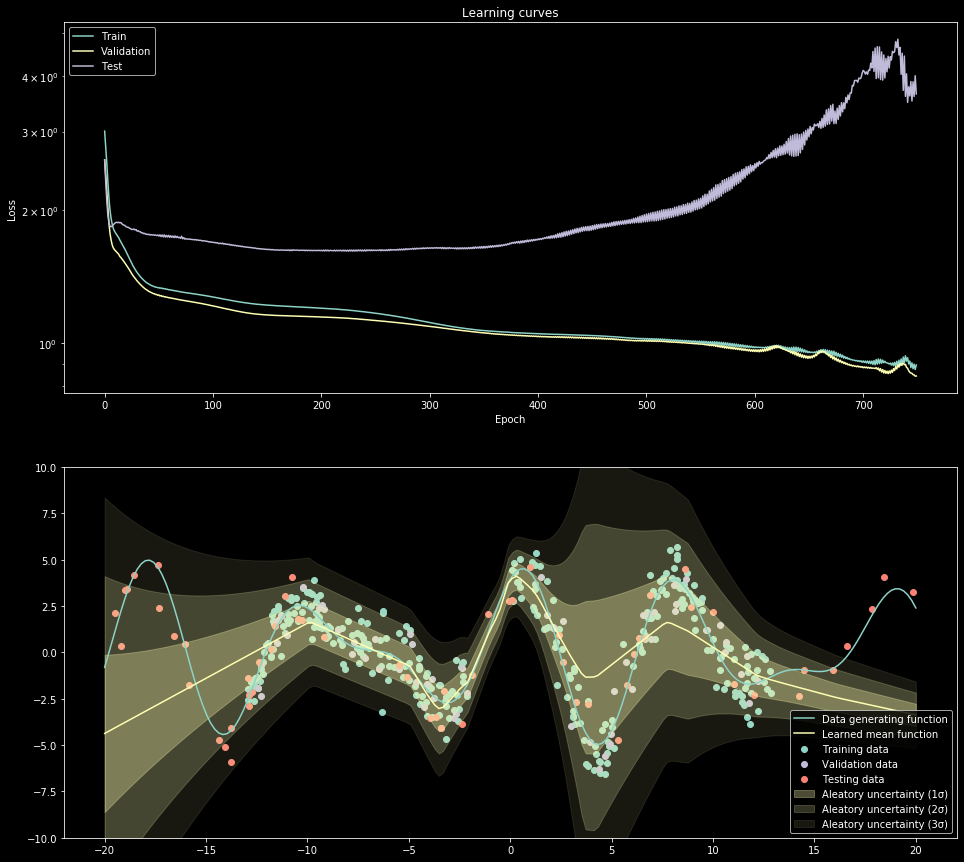

Epoch 999 | Train loss 0.587 | Val loss 0.584 | Test loss 3.662

In [19]:
train(dpl_model, optimizer, gaussian_nll_loss, dataloader_train, dataloader_val, dataloader_test, 1000)

## Ensemble Averaging

Combine several distributional parameter learning models each of which having learned a Gaussian distribution over the output given the input into a Guasisna mixture distribution.

Compute the mean and variance of the mixture distribution and use that as the ensen


Epoch 999 | Train loss 0.471 | Val loss 0.520 | Test loss 14.587

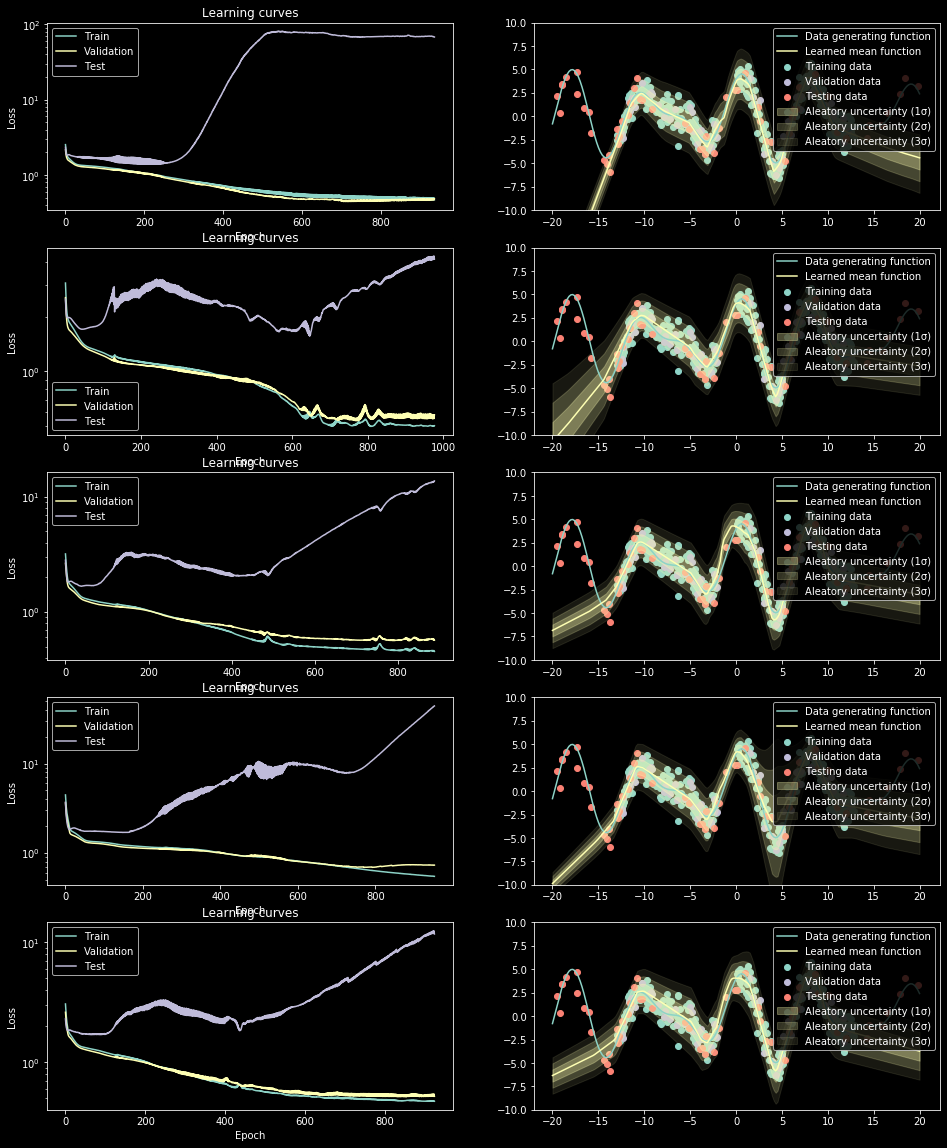

In [26]:
fig, axes = plt.subplots(N_ENSEMBLE_MODELS, 2, figsize=(16, 20))
ensemble_models = []
for i in range(N_ENSEMBLE_MODELS):
    dpl_model = DPLModel()
    dpl_model.to(device)
    ensemble_models.append(dpl_model)

for i, model in enumerate(ensemble_models):
    print(f'Model {i}')
    gaussian_nll_loss = GaussianNLLLoss()
    gaussian_nll_loss.to(device)
    optimizer = optim.Adam(model.parameters(), lr=3e-4)
    train(model, optimizer, gaussian_nll_loss, dataloader_train, dataloader_val, dataloader_test, 1000, fig=fig, ax_train=axes[i, 0], ax_func=axes[i, 1])

In [27]:
class EnsembleDPLModel(nn.Module):
    """Distributional Parameter Learning Model using Gaussian"""
    def __init__(self, models):
        super().__init__()
        self.models = models
        for i_model, model in enumerate(self.models):
            setattr(self, f'dpl_model_{i_model}', model)

    def forward(self, x): # TODO
        mus, logvars = [], []
        for model in self.models:
            mu, logvar = model.forward(x)
            mus.append(mu)
            logvars.append(logvar)
        return torch.stack(mus), torch.stack(logvars)

    def predict(self, x):
        mus, logvars = self.forward(x)
        mean_of_mu = torch.mean(mus, axis=0)
        mean_of_variance  = torch.mean(logvars.exp(), axis=0)
        variance_of_mu =  torch.mean(mus.pow(2) - mean_of_mu.pow(2), axis=0)

        return mean_of_mu, (mean_of_variance, variance_of_mu)

In [28]:
# Collect the mod
ensemble_dpl_model = EnsembleDPLModel(ensemble_models)
ensemble_dpl_model = ensemble_dpl_model.to(device)

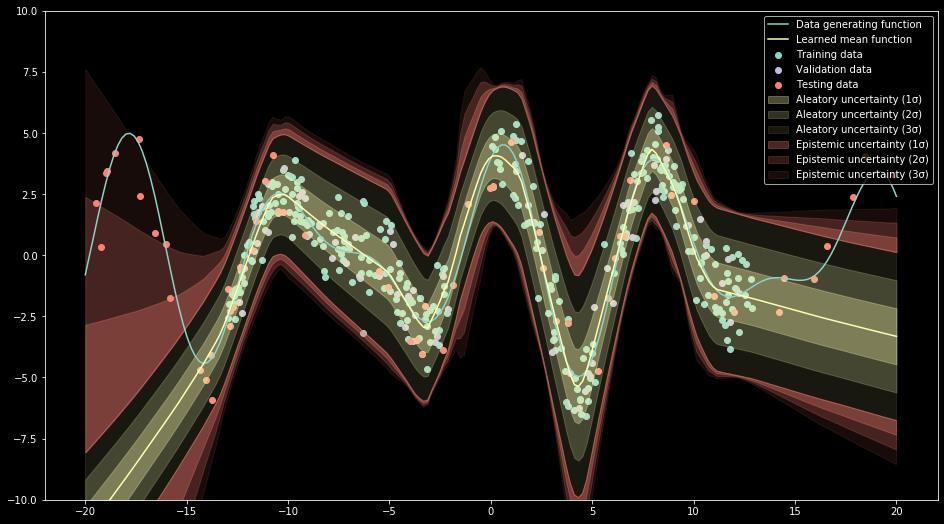

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(16, 9))

plot_learned_function(ax, ensemble_dpl_model, x_plot)
display.display(fig)
display.clear_output(wait=True)

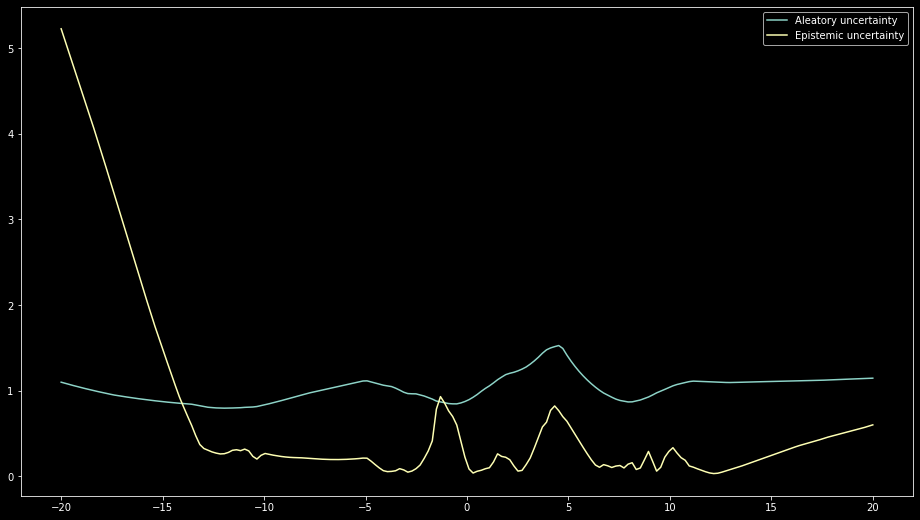

In [32]:
with torch.no_grad():
    x_plot_tensor = torch.Tensor(x_plot.reshape(-1, 1))
    x_plot_tensor.to(device)
    y_pred, (aleatory_var, epistemic_var) = ensemble_dpl_model.predict(x_plot_tensor)
    y_pred = y_pred.flatten()
    aleatory_std = aleatory_var.flatten().sqrt()
    epistemic_std = epistemic_var.flatten().sqrt()

fig, ax = plt.subplots(1, 1, figsize=(16, 9))
ax.plot(x_plot, aleatory_std, label='Aleatory uncertainty')
ax.plot(x_plot, epistemic_std, label='Epistemic uncertainty')
ax.legend()

## To do
- Dropout ensembles
- Quantile Regression
- Gaussian process baseline
- Write methodology of distributional parameter learning and Gaussian mixture of such models (ensemble)
- Kullback-Leibler divergence between true data generating function/distribution and the modelled one for each of the methods in a plot as function of training time



# References
[1] Yarin Gal. 2017. Uncertainty in Deep Learning. PhD Thesis.

[2] Nitish, Hinton, et al. 2014. Dropout: A Simple Way to Prevent Neural Networks from Overﬁtting.


[10] https://en.wikipedia.org/wiki/Uncertainty_quantification

[11] https://www.inovex.de/blog/uncertainty-quantification-deep-learning/